# Análisis de literatura científica con ChatGPT

# 1. Configuración del entorno

En esta seccion iniciaremos con la configuración del entorno necesario para establecer la conexión con la API de OpenAI y poder interactuar con ChatGPT directamente desde un entorno de Jupyter Notebook. Inicialmente se deben de instalar las librerias y activar las llaves de nuestra cuenta de OpenAI. Si estas usando este laboratorio en Google Colab con las siguientes lineas de codigo se instalaran las librerias, sin embargo si tu quieres instalar estas librerias a nivel local las lineas debes ejecutar esta linea. Recuerda también que si corres este notebook en un entorno local deberas contar con las librerias numpy, pandas y matplotlib.

```
!pip install openai==0.28
```

## Importante:
Este laboratorio utiliza la API de OpenAI, la cual puede presentar fluctuaciones en el tráfico y tiempos de respuesta. Si la ejecución de la celda es considerablemente lenta, se sugiere reiniciarla y ejecutarla nuevamente.

En términos generales, el tiempo de ejecución de todas las celdas no debería exceder los 5 minutos. Sin embargo, es importante tener en cuenta que la celda dedicada a la traducción de los abstracts puede tardar un poco más debido a la complejidad del proceso.

Si la ejecución excede el tiempo estimado o si el sistema retorna un error de conexión, se recomienda verificar la conexión a internet o detener la ejecución para luego volver a ejecutar la celda correspondiente.

Debido a las restricciones de OpenAI, no es posible realizar solicitudes consecutivas a la API. Se recomienda esperar un período antes de lanzar la siguiente solicitud, una vez que la anterior haya sido completada. Por esta razón, el notebook está configurado con un tiempo de espera entre cada solicitud. En caso de que se observe un error relacionado con esto, por favor, aumente el tiempo entre solicitudes consecutivas `(time.sleep(tiempo_entre_solicitudes))`.

## 1.1 Cargar librerias del entorno

Inicialmente se realiza el llamado a la libreria de `openia` la cual permite la conexión con ChatGPT. En esta fase también se incluyen librerias como `pandas` y `numpy`.

In [1]:
!pip install openai==0.28

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 1.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.


In [2]:
import time  # Importa la libreria para trabajar con funciones relacionadas con el tiempo.

import openai  # Importa la API de OpenAI para acceder a las funcionalidades proporcionadas por OpenAI,
               # como modelos de lenguaje.

import numpy as np  # Importa la libreria NumPy para realizar cálculos numéricos.
import pandas as pd  # Importa la libreria Pandas para manipular y analizar datos en formatos DataFrame.
import matplotlib.pyplot as plt  # Importa el módulo 'pyplot' de Matplotlib para crear visualizaciones.

## 1.2.  Creación de una cuenta y credenciales de OpenAI

Para comenzar, es necesario tener una cuenta en la plataforma de OpenAI y obtener las credenciales de la API. Estas credenciales son esenciales para autenticar nuestras solicitudes y acceder a los servicios ofrecidos por la API de ChatGPT.

- Registro en OpenAI: Si aún no tienes una cuenta en la plataforma, puedes crear una en [OpenAI](https://openai.com/). Para la cuenta necesitas un correo y un número telefonico valido.
- Generación de Claves de API: Una vez creada la cuenta, en el panel de control de OpenAI, encontrarás la sección de API donde podrás generar claves. Asegúrate de guardar estas claves de manera segura, ya que serán utilizadas para la autenticación. La siguientes imagenes indican como debes acceder para encontrar tus claves de autentificación.

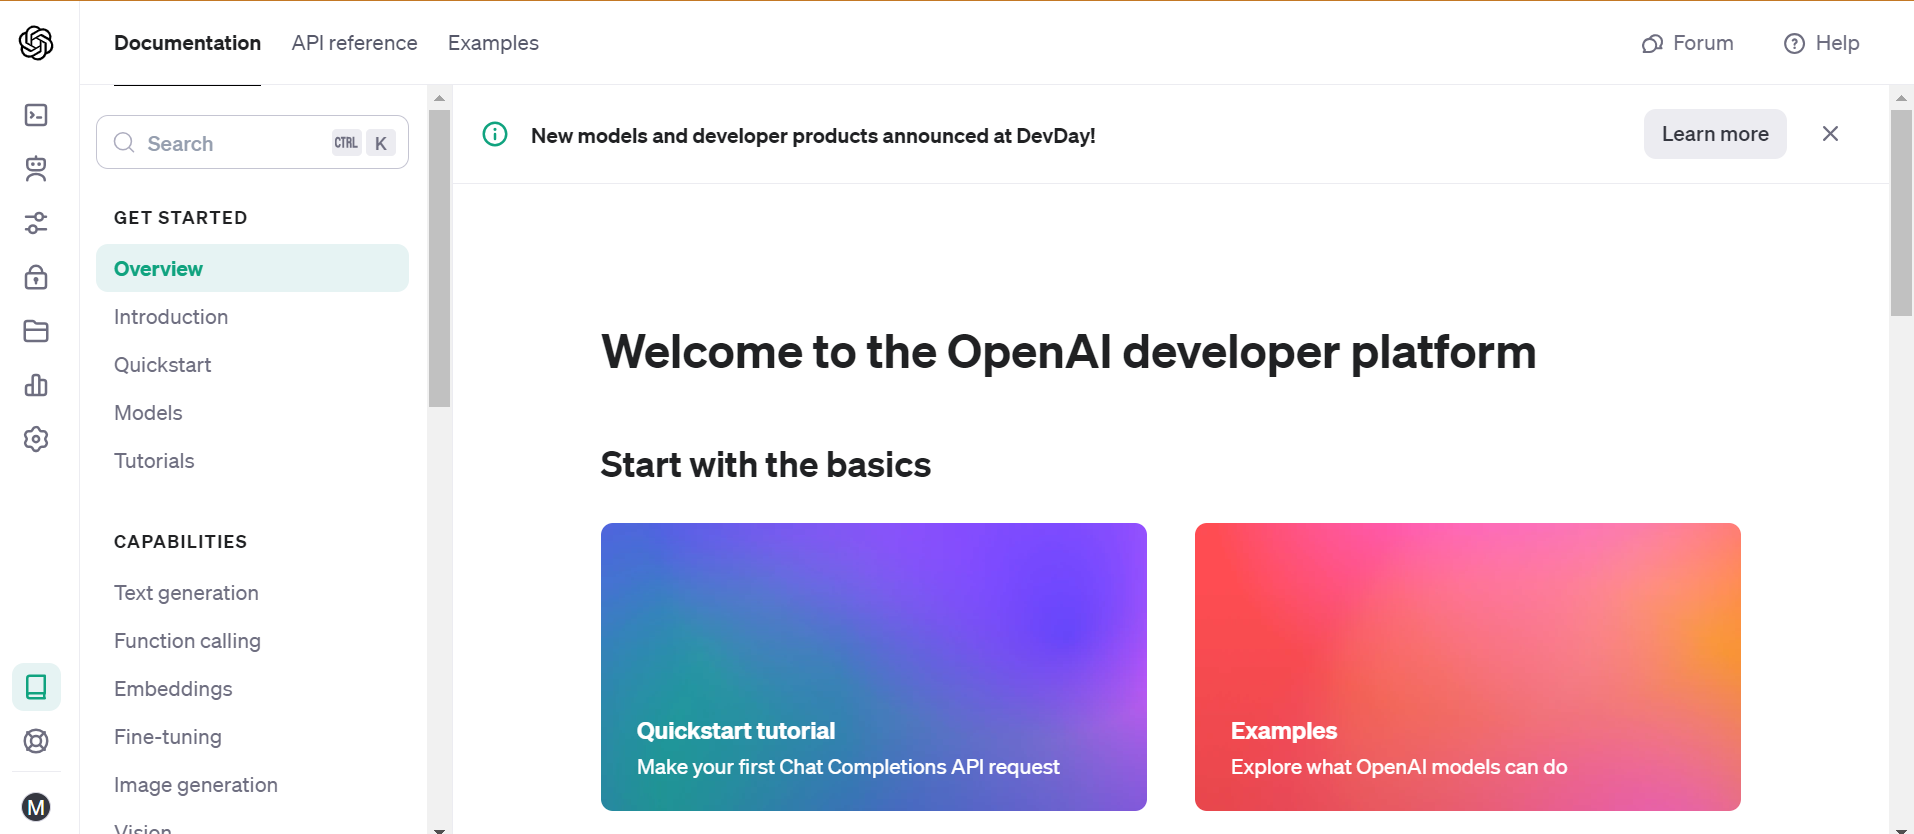

En la página de inicio, dirígete hacia el extremo izquierdo de la pantalla. Allí, verás el logotipo ubicado en la esquina superior izquierda; al hacer clic en este logotipo, se desplegará el siguiente menú.

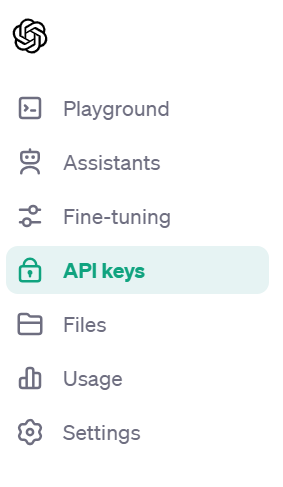

Una vez en el menú, selecciona la opción 'Api Keys', lo que mostrará la siguiente ventana.

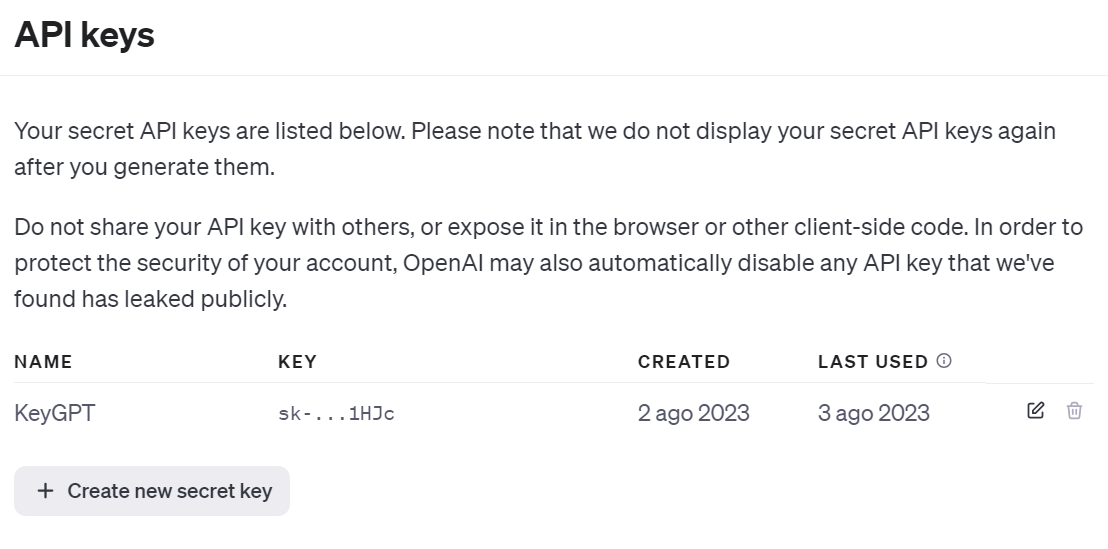

En este punto, puedes acceder a la opción 'Create new secret Key' si no has creado ninguna llave previamente. Una vez generada, asegúrate de copiarla para su uso posterior.

En este laboratorio necesitamos que incluyas tus claves, recuerda no compartirlas con nadie, por esta razón no debes subir este notebook solo la tarea que se indica al finalizar.

In [3]:
## Aqui va tu API KEY, ubica esta cadena entre comillas.
openai.api_key  = "API KEY"

# 2. Comunicación con GPT

En este laboratorio, haremos uso del modelo GPT-3.5-turbo de OpenAI junto con el endpoint de chatcompletion. Para simplificar el proceso de envío de indicaciones y visualización de las salidas generadas, hemos creado la siguiente función auxiliar.

## 2.1 Función para generar peticiones

In [4]:
def get_completion(prompt, model="gpt-3.5-turbo"):
    """
    Esta función utiliza el modelo especificado de OpenAI para generar una respuesta
    basada en la indicación proporcionada (promt).

    Args:
    - prompt (str): La indicación o mensaje inicial que se utilizará para generar
                    la respuesta.
    - model (str): El nombre del modelo de OpenAI que se utilizará. Por defecto,
                    se utiliza "gpt-3.5-turbo".

    Returns:
    - str: La respuesta generada por el modelo basada en la indicación dada.
    """

    # Preparación del mensaje de entrada en el formato requerido por la API de OpenAI
    messages = [{"role": "user", "content": prompt}]

    # Creación de la solicitud de completado de chat utilizando la API de OpenAI
    response = openai.ChatCompletion.create(
        model =  model,
        messages = messages,
        temperature = 1,  # Este parámetro controla el grado de aleatoriedad en la salida del modelo
    )

    # Retorna la respuesta generada por el modelo
    return response.choices[0].message["content"]


Para confirmar el correcto funcionamiento de la función, consideremos el siguiente ejemplo. En esta instancia, solicitamos a ChatGPT que comparta información interesante en una extensión de 10 palabras.

In [5]:
get_completion('cuentame un dato fascinante en exactamente 10 palabras')

'Los pulpos tienen tres corazones y nueve cerebros simultáneamente funcionales.'

## 2.2 Prompting

Prompting es la forma en que los seres humanos pueden comunicarse con las inteligencias artificiales. Se trata de expresar a la IA qué necesitamos y cómo lo necesitamos, empleando palabras y estructuras precisas. La ingeniería de prompts se convierte así en una tarea vital para encontrar la formulación ideal que brinde los resultados óptimos de la IA.

Algunas estrategias clave para construir prompts efectivos son:

- Claridad en las instrucciones: Es vital redactar instrucciones claras y directas para obtener respuestas precisas de la IA. La formulación precisa y fácil de entender es fundamental para la obtención de resultados coherentes.

- Uso de delimitadores: La inclusión de delimitadores claros, como comillas simples o triples (' ', ''' '''), comillas dobles (" "), etiquetas HTML `(<tag></tag>)`, entre otros, es esencial para estructurar la información y destacar partes clave en la solicitud.

- Desglose de tareas complejas: En tareas complejas, descomponer el objetivo en subtareas más manejables y organizadas puede ser beneficioso. Abordar estas partes por separado permite formular indicaciones más específicas y precisas, facilitando la obtención de resultados concretos.

- Contextualización y detalles relevantes: Proporcionar contexto adecuado y detalles relevantes en la solicitud puede mejorar significativamente la comprensión de la IA y, por ende, la calidad de sus respuestas.

# 3. Análisis de literatura científica con ChatGPT

Esta sección presenta una aplicación práctica del uso de ChatGPT para analizar conjuntos de información, específicamente en el contexto de la investigación científica y la revisión de literatura académica.

En el proceso de investigación la revisión de artículos científicos suele ser un paso fundamental. Esta fase inicial puede resultar extensa, ya que implica la selección, lectura y análisis de múltiples títulos y resúmenes de artículos. El investigador debe depurar y seleccionar aquellos que serán examinados con mayor detalle. Automatizar y agilizar este proceso inicial puede ser beneficioso y aquí es donde un modelo generativo del lenguaje puede ofrecer ventajas significativas.

Para nuestro laboratorio se dispone de un archivo XLSX que contiene títulos y resúmenes de 10 artículos. Si bien en la práctica el número de artículos podría ser considerablemente mayor, para este laboratorio nos enfocaremos en el análisis de estos 10 ejemplos. Utilizaremos la herramienta de ChatGPT desde el entorno de Jupyter Notebook para aprovechar la automatización y eficiencia que proporciona.

La capacidad de automatizar la revisión preliminar de la literatura científica utilizando ChatGPT desde Jupyter Notebook representa una oportunidad para acelerar y simplificar la fase inicial de investigación, proporcionando así una base para un análisis más exhaustivo y detallado.

## 3.1 Cargar archivo con títulos y resumenes de artículos

Para cargar la información del archivo, se emplea la librería Pandas. Una vez cargada, se utiliza el método `.info()` de Pandas para visualizar la cantidad de elementos y se muestran los nombres de las columnas del DataFrame.

In [6]:
df = pd.read_excel('articulos.xlsx')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Title     10 non-null     object
 1   Abstract  10 non-null     object
dtypes: object(2)
memory usage: 288.0+ bytes


In [8]:
print(df.columns)

Index(['Title', 'Abstract'], dtype='object')


## 3.2. Análisis de los títulos de los artículos

El título de un artículo resume y presenta la investigación realizada. Este título puede ser útil para filtrar elementos de interés o identificar investigaciones acordes a nuestros intereses. Podemos identificar el tema principal de cada título o verificar si un tema específico está explícitamente mencionado en cada uno. Otra análisis consiste en unir todos los títulos para determinar los temas generales de estas investigaciones o para crear un resumen basado en la información proporcionada por los títulos. Vamos a explorar estos análisis.

### Temas generales y áreas generales identificados en los títulos

In [11]:
# Creamos una lista vacía para almacenar los temas globales identificados en los títulos
topicsTitles = []

# Iteramos a través de los títulos del DataFrame
for title in df['Title']:
    # Creamos un prompt para obtener un resumen del tema general del artículo en 4 palabras
    prompt = f"""
    Find the article main topic based on its title.
    Title: "{title}"
    """
    # Utilizamos la función get_completion para obtener la respuesta utilizando el prompt
    response = get_completion(prompt)

    # Añadimos la respuesta a la lista de temas globales identificados en los títulos
    # esta lista puede ser útil si despues se quiere agregar una columna a la hoja de excel
    # incluyendo los temas identificados.
    topicsTitles.append(response)

    # Imprimimos el título y el tema global identificado por ChatGPT
    print(f'Título artículo: {title}.\nTema identificado: {response}')
    print('\n')
    time.sleep(20)

Título artículo: Donation Networks in Underprivileged Communities.
Tema identificado: The main topic of the article is "Donation Networks in Underprivileged Communities".


Título artículo: Rotating savings and credit associations: A scoping review.
Tema identificado: The main topic of the article is "Rotating savings and credit associations".


Título artículo: Feedback Control Engineering for Cooperative Community Development.
Tema identificado: The article main topic is "Feedback Control Engineering for Cooperative Community Development".


Título artículo: Dynamics of Cooperation in a Task Completion Social Dilemma.
Tema identificado: The article's main topic is the dynamics of cooperation in a social dilemma related to task completion.


Título artículo: Understanding the World to Solve Social Dilemmas Using Multi-Agent Reinforcement Learning.
Tema identificado: The main topic of the article is "Understanding the World to Solve Social Dilemmas Using Multi-Agent Reinforcement Learn

In [13]:
# Creamos una lista vacía para almacenar los campos de estudio
fieldTitles = []

# Iteramos a través de los títulos del DataFrame
for title in df['Title']:
    # Creamos un prompt para obtener el posible campo de estudio del artículo
    # También le sugerimos que de la respuesta numerada por cada área.
    prompt = f"""
    Based on the article's title, indicate the fields of study or research areas this paper belongs to.
    Article Title:"{title}"
    Provide your response numbered according to the fields
    """
    # Utilizamos la función get_completion para obtener la respuesta utilizando el prompt
    response = get_completion(prompt)

    # Añadimos la respuesta a la lista de campos de estudio
    # esta lista puede ser útil si despues se quiere agregar una columna a la hoja de excel
    # incluyendo los temas identificados.
    fieldTitles.append(response)

    # Imprimimos el título y el tema global identificado por ChatGPT
    print(f'Título artículo: {title}.\nÁreas del conocimiento identificadas:\n{response}')
    print('\n')
    time.sleep(20)

Título artículo: Donation Networks in Underprivileged Communities.
Áreas del conocimiento identificadas:
1. Social Sciences
2. Sociology
3. Public Health
4. Community Development
5. Economics


Título artículo: Rotating savings and credit associations: A scoping review.
Áreas del conocimiento identificadas:
1. Economics 
2. Finance 
3. Microfinance 
4. Social finance 
5. Community development


Título artículo: Feedback Control Engineering for Cooperative Community Development.
Áreas del conocimiento identificadas:
1. Feedback Control Engineering
2. Cooperative Community Development


Título artículo: Dynamics of Cooperation in a Task Completion Social Dilemma.
Áreas del conocimiento identificadas:
1. Game theory
2. Social psychology
3. Sociology
4. Behavioral economics
5. Cultural anthropology


Título artículo: Understanding the World to Solve Social Dilemmas Using Multi-Agent Reinforcement Learning.
Áreas del conocimiento identificadas:
1. Artificial Intelligence and Machine Learnin

### Categorias globales y clasificación de cada artículo

Ahora procederemos a combinar todos los títulos y preguntar a qué categorías se relacionan estas investigaciones. Además, solicitaremos al modelo de lenguaje que nos devuelva la respuesta en un formato que nos permita convertirla fácilmente en una lista de Python. También le indicaremos que genere solamente un número determinado de categorías.

In [14]:
# Inicializamos una cadena vacía para almacenar los títulos combinados
titles = ''

# Iteramos a través de los títulos del DataFrame df
for title in df['Title']:
    # Agregamos cada título a la cadena 'titles', junto con un formato para separarlos
    titles = f"""
    ```{title}``` \n {titles}
    """

# Al finalizar el bucle, 'titles' contendrá todos los títulos combinados con un formato de separación

In [15]:
# Creación del prompt
# En el prompt le indicamos la estructura de los título, le sugerimos un número de categorias
# y planteamos que solo identifique las categorias con un número limitado de palabras
# además se indica el formato de la respuesta y se recalca que solo se requieren 5 categorias
prompt = f"""
    Now see a list of article titles separated by /n and enclosed in quotation marks.
    From these titles, tell me in a total of 5 categories encompassing the themes you identify, using one or a maximum of three words per category.
    Return them in the format: Category1, Category2, ... Category5
    I only need 5 categories from everything you read.
    Titles: {titles}
    """

# Obteniendo las categorías identificadas utilizando la función get_completion con el prompt creado
categoriesIdentify = get_completion(prompt)

In [16]:
# Dividir la cadena de categorías identificadas en una lista utilizando la coma
# y el espacio como separadores

categoriesIdentify = categoriesIdentify.split(', ')

# Imprimir el total de categorías identificadas en la lista resultante
print(f'Total de categorías identificadas: {len(categoriesIdentify)}')
print(f'Categorias {categoriesIdentify}')

Total de categorías identificadas: 5
Categorias ['Resilience', 'Mathematics', 'Decentralization', 'Cooperation', 'Financial Management']


Ahora clasificaremos los titulos de acuerdo con las 5 categorias identificadas.

In [17]:
# Creación de una lista vacía para almacenar las categorías asignadas a cada título
categoryTitle = []

# Iteración a través de los títulos
for title in df['Title']:
    # Creación del prompt para clasificar cada título en una o varias de las categorías identificadas anteriormente
    prompt = f"""
    Classify the following title into one or more of these categories: {categoriesIdentify}.
    ```{title}```
    Please respond only with the words of the category it belongs to, no more.
    """
    # Obtiene la respuesta utilizando la función get_completion con el prompt creado
    response = get_completion(prompt)

    # Agrega la respuesta a la lista categoryTitle
    categoryTitle.append(response)
    # Imprimimos el título y la categoria asiganda de las 10 identificadas
    print(f'Título artículo: {title}.\nCategoria(s) asignada(s): {response}')
    print('\n')
    time.sleep(20)

Título artículo: Donation Networks in Underprivileged Communities.
Categoria(s) asignada(s): Cooperation


Título artículo: Rotating savings and credit associations: A scoping review.
Categoria(s) asignada(s): Financial Management


Título artículo: Feedback Control Engineering for Cooperative Community Development.
Categoria(s) asignada(s): Cooperation


Título artículo: Dynamics of Cooperation in a Task Completion Social Dilemma.
Categoria(s) asignada(s): Cooperation


Título artículo: Understanding the World to Solve Social Dilemmas Using Multi-Agent Reinforcement Learning.
Categoria(s) asignada(s): Cooperation


Título artículo: Resilient Structural Sparsity in the Design of Consensus Networks.
Categoria(s) asignada(s): Resilience


Título artículo: Feedback Control Engineering for Cooperative Community Development: Tools for Financial Management Advice for Low-Income Individuals.
Categoria(s) asignada(s): Resilience, Cooperation, Financial Management


Título artículo: Distributed

Estas categorias nos permiten realizar por ejemplos graficos de barras para ver cuantos artículos hay en cada una. A continuación realizaremos un diagrama de este tipo.

In [18]:
# Creamos un diccionario con las categorías identificadas como claves
# y se inicializan con un conteo de 0
dicCountCategories = {category: 0 for category in categoriesIdentify}

# Iteramos a través de las categorías asignadas a cada título
for category in categoryTitle:
    # Dividimos las categorías asignadas en una lista
    totalCategory = category.split(',')

    # Iteramos sobre cada categoría asignada a un título
    for eachCategory in totalCategory:
        # Eliminamos espacios en blanco adicionales al inicio de cada categoría, si los hay
        if eachCategory[0] == ' ':
            eachCategory = eachCategory[1:]

        # Comparamos cada categoría asignada con las categorías identificadas previamente
        for classCategory in categoriesIdentify:
            # Si una categoría asignada coincide con una categoría identificada, aumentamos el contador en el diccionario
            if eachCategory == classCategory:
                dicCountCategories[eachCategory] += 1

# Devolvemos el diccionario con el recuento de cada categoría identificada en los títulos
dicCountCategories

{'Resilience': 4,
 'Mathematics': 1,
 'Decentralization': 0,
 'Cooperation': 6,
 'Financial Management': 2}

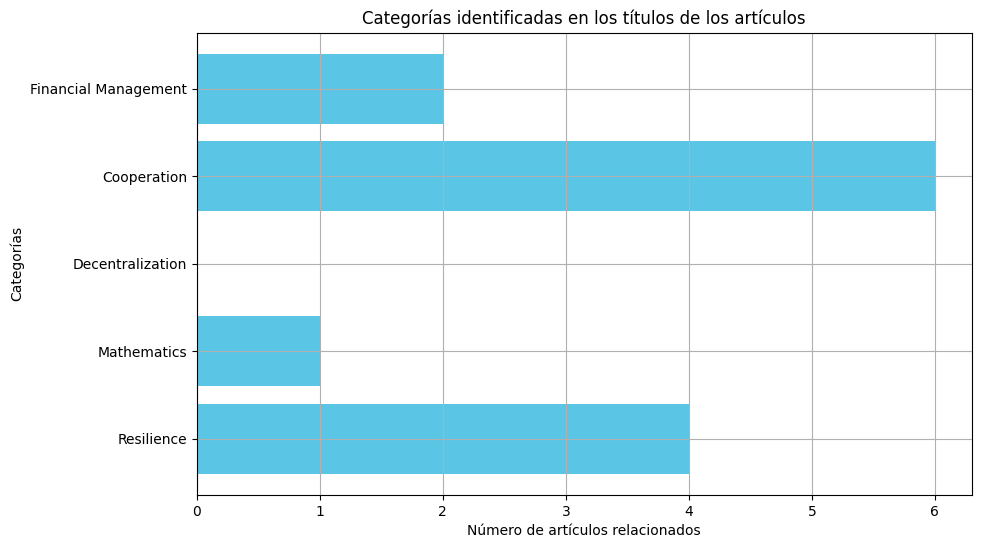

In [19]:
# Obtener las categorías como una lista de nombres de clases
class_names = list(dicCountCategories.keys())

# Obtener los recuentos de cada categoría como una lista de valores de clases
class_counts = list(dicCountCategories.values())

# Crear un gráfico de barras horizontal
plt.figure(figsize=(10, 6))  # Definir el tamaño del gráfico
plt.barh(class_names, class_counts, color='#5bc5e5')  # Crear el gráfico de barras horizontales
plt.xticks(range(max(class_counts) + 1))  # Establecer el rango del eje x según el recuento máximo de categorías
# Agregar etiquetas y título al gráfico
plt.xlabel('Número de artículos relacionados')  # Etiqueta para el eje x
plt.ylabel('Categorías')  # Etiqueta para el eje y
plt.title('Categorías identificadas en los títulos de los artículos')  # Título del gráfico
plt.grid()  # Mostrar cuadrícula en el gráfico
# Mostrar el gráfico de barras
plt.show()

## 3.3 Análisis de los resúmenes (*Abstracts*) de los artículos

A diferencia de los títulos, los resúmenes proporcionan información más detallada y completa. Además de presentar el propósito de la investigación y los resultados, también ofrecen una visión más amplia al presentar la metodología y una contextualización del tema. Estas características hacen que los resúmenes sean una elección ideal para el análisis y la extracción de información.

En esta sección, emplearemos la información de los resúmenes para clasificar, analizar y extraer datos de los artículos bajo análisis. El enfoque en los resúmenes nos permitirá una comprensión más profunda de la investigación realizada en cada artículo.

### Identificar la presencia de un tema específico

A veces, es necesario determinar si un artículo aborda un tema particular dentro del contexto más amplio. Aunque los artículos seleccionados como ejemplo de este laboratorio siguen una línea investigativa como se pudo constatar en el análisis de los títulos, se examinará cómo clasificar cada uno en relación con la inclusión o exclusión de temas relacionados con **estrategias para mejorar la cooperación financiera**. Para realizar esta evaluación, indagaremos si el resumen permite inferir la inclusión o exclusión de este tema específico.

In [20]:
# Creación de una lista vacía para almacenar la presencia del tema de cooperación financiera en los artículos
financialCooperation = []

# Iteración a través de los abstracts y títulos del DataFrame df
for abstract, title in zip(df['Abstract'], df['Title']):
    # Creación del prompt en inglés para determinar si el artículo trata sobre estrategias para mejorar la cooperación financiera
    prompt = f"""
    Tell me if, after reading the following abstract of an article, it can be inferred that the article discusses strategies to improve financial cooperation.
    Respond with Yes or No.
    ```{abstract}```
    """
    # Obtención de la respuesta utilizando la función get_completion con el prompt creado
    response = get_completion(prompt)

    # Agregar la respuesta a la lista financialCooperation
    financialCooperation.append(response)

    # Imprimir por cada artículo si el tema es abordado o no
    print(f'Título artículo: {title}.\nEstrategias de cooperación financiera: {response}')
    print('\n')
    time.sleep(20)


Título artículo: Donation Networks in Underprivileged Communities.
Estrategias de cooperación financiera: Yes


Título artículo: Rotating savings and credit associations: A scoping review.
Estrategias de cooperación financiera: Yes


Título artículo: Feedback Control Engineering for Cooperative Community Development.
Estrategias de cooperación financiera: Yes


Título artículo: Dynamics of Cooperation in a Task Completion Social Dilemma.
Estrategias de cooperación financiera: Yes


Título artículo: Understanding the World to Solve Social Dilemmas Using Multi-Agent Reinforcement Learning.
Estrategias de cooperación financiera: No


Título artículo: Resilient Structural Sparsity in the Design of Consensus Networks.
Estrategias de cooperación financiera: No


Título artículo: Feedback Control Engineering for Cooperative Community Development: Tools for Financial Management Advice for Low-Income Individuals.
Estrategias de cooperación financiera: No.


Título artículo: Distributed Reconfig

### Categorias globales y clasificación de cada artículo

Similar a la estrategia empleada en la sección de análisis de títulos, ahora se consolidan todos los *abstracts* en un único texto. A partir de esta recopilación, se solicitará a la inteligencia artificial que identifique las posibles categorías relacionadas con estas investigaciones. Los resultados obtenidos pueden compararse con los resultados de la sección de análisis de títulos.

Al igual que en esa sección, se pedirá al modelo de lenguaje que entregue la respuesta en un formato que permita su conversión sencilla a una lista de Python. Asimismo, se especificará que solo se requiere un número determinado de categorías para facilitar su manejo. Al finalizar la sección se genera al diagrama de barras de recuento de artículos en cada categoria.

In [21]:
# Inicialización de una cadena vacía para almacenar todos los abstracts combinados
abstracts = ''

# Iteración a través de los abstracts de los artículos
for abstract in df['Abstract']:
    # Combinación de cada resumen en la cadena 'abstracts' con un formato para separarlos
    abstracts = f"""
    ```{abstract}``` \n {abstracts}
    """

In [25]:
# Creación del prompt
# En el prompt le indicamos la estructura de los abstracts, le sugerimos un número de categorias
# y planteamos que solo identifique las categorias con un número limitado de palabras
# además se indica el formato de la respuesta y se recalca que solo se requieren 5 categorias
prompt = f"""
    Now see a list of article abstracts separated by /n and enclosed in quotation marks.
    From these abstracts, tell me in a total of 5 categories encompassing the themes you identify, using one or a maximum of three words per category.
    Return them in the format: Category1, Category2, ... Category5
    each word separated by ,
    I only need 5 categories from everything you read.
    Titles: {abstracts}
    """

# Obteniendo las categorías identificadas utilizando la función get_completion con el prompt creado
categoriesIdentifyAbstracts = get_completion(prompt)

In [26]:
# Dividir la cadena de categorías identificadas en una lista utilizando la coma
# y el espacio como separadores

categoriesIdentifyAbstracts = categoriesIdentifyAbstracts.split(', ')

# Imprimir el total de categorías identificadas en la lista resultante
print(f'Total de categorías identificadas: {len(categoriesIdentifyAbstracts)}')
print(f'Categorias {categoriesIdentifyAbstracts}')

Total de categorías identificadas: 5
Categorias ['Community Resilience', 'Financial Organizations', 'Decision-Making', 'Consensus Systems', 'Social Dilemmas']


In [27]:
# Creación de una lista vacía para almacenar las categorías asignadas a cada título
categoryAbstract = []

# Iteración a través de los títulos y abstracts
for abstract, title in zip(df['Abstract'],df['Title']):
    # Creación del prompt para clasificar cada título en una o varias de las categorías identificadas anteriormente
    prompt = f"""
    Classify the following abstract into one or more of these categories: {categoriesIdentifyAbstracts}.
    ```{abstract}```
    Please respond only with the words of the category it belongs to, no more.
    """
    # Obtiene la respuesta utilizando la función get_completion con el prompt creado
    response = get_completion(prompt)

    # Agrega la respuesta a la lista categoryTitle
    categoryAbstract.append(response)
    # Imprimimos el título y la categoria asiganda de las 10 identificadas
    print(f'Título artículo: {title}.\nCategoria(s) asignada(s): {response}')
    print('\n')
    time.sleep(20)

Título artículo: Donation Networks in Underprivileged Communities.
Categoria(s) asignada(s): ['Community Resilience', 'Financial Organizations', 'Decision-Making']


Título artículo: Rotating savings and credit associations: A scoping review.
Categoria(s) asignada(s): Community Resilience, Financial Organizations, Decision-Making


Título artículo: Feedback Control Engineering for Cooperative Community Development.
Categoria(s) asignada(s): Decision-Making
Financial Organizations
Community Resilience


Título artículo: Dynamics of Cooperation in a Task Completion Social Dilemma.
Categoria(s) asignada(s): Social Dilemmas


Título artículo: Understanding the World to Solve Social Dilemmas Using Multi-Agent Reinforcement Learning.
Categoria(s) asignada(s): Social Dilemmas


Título artículo: Resilient Structural Sparsity in the Design of Consensus Networks.
Categoria(s) asignada(s): Consensus Systems, Community Resilience


Título artículo: Feedback Control Engineering for Cooperative Comm

In [28]:
# Creamos un diccionario con las categorías identificadas como claves
# y se inicializan con un conteo de 0
dicCountCategories = {category: 0 for category in categoriesIdentifyAbstracts}

# Iteramos a través de las categorías asignadas a cada abstract
for category in categoryAbstract:
    # Dividimos las categorías asignadas en una lista
    totalCategory = category.split(',')

    # Iteramos sobre cada categoría asignada a un título
    for eachCategory in totalCategory:
        # Eliminamos espacios en blanco adicionales al inicio de cada categoría, si los hay
        if eachCategory[0] == ' ':
            eachCategory = eachCategory[1:]

        # Comparamos cada categoría asignada con las categorías identificadas previamente
        for classCategory in categoriesIdentifyAbstracts:
            # Si una categoría asignada coincide con una categoría identificada, aumentamos el contador en el diccionario
            if eachCategory == classCategory:
                dicCountCategories[eachCategory] += 1

# Devolvemos el diccionario con el recuento de cada categoría identificada
dicCountCategories

{'Community Resilience': 4,
 'Financial Organizations': 3,
 'Decision-Making': 5,
 'Consensus Systems': 3,
 'Social Dilemmas': 3}

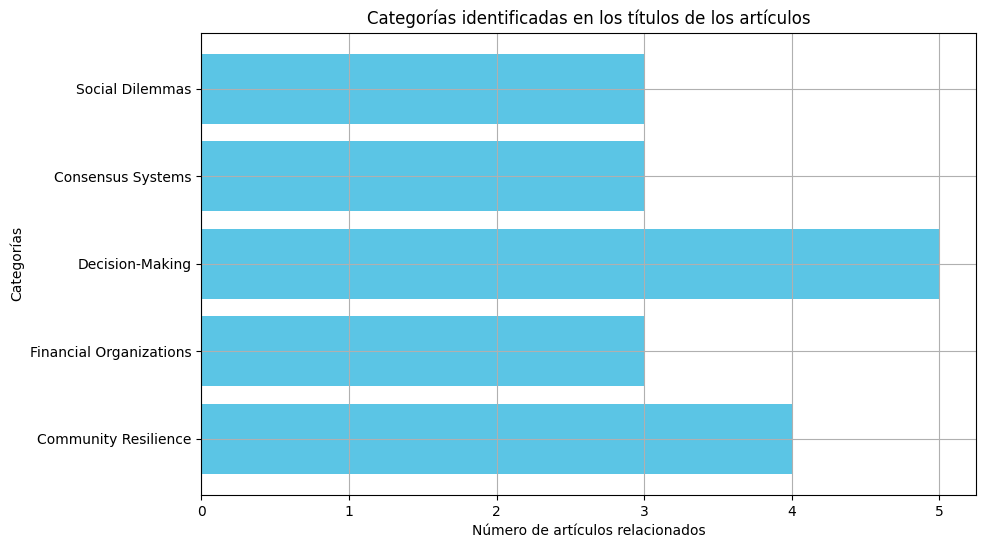

In [29]:
# Obtener las categorías como una lista de nombres de clases
class_names = list(dicCountCategories.keys())

# Obtener los recuentos de cada categoría como una lista de valores de clases
class_counts = list(dicCountCategories.values())

# Crear un gráfico de barras horizontal
plt.figure(figsize=(10, 6))  # Definir el tamaño del gráfico
plt.barh(class_names, class_counts, color='#5bc5e5')  # Crear el gráfico de barras horizontales
plt.xticks(range(max(class_counts) + 1))  # Establecer el rango del eje x según el recuento máximo de categorías
# Agregar etiquetas y título al gráfico
plt.xlabel('Número de artículos relacionados')  # Etiqueta para el eje x
plt.ylabel('Categorías')  # Etiqueta para el eje y
plt.title('Categorías identificadas en los títulos de los artículos')  # Título del gráfico
plt.grid()  # Mostrar cuadrícula en el gráfico
# Mostrar el gráfico de barras
plt.show()

### Resumir y traducir al español

Los modelos generativos de lenguaje presentan una ventaja notable al ofrecer la capacidad de traducción entre idiomas. Esta habilidad resulta útil al realizar traducciones automáticas de los resúmenes de artículos, permitiéndonos solicitar un resumen del contenido en nuestro idioma. Además, estos modelos también permiten ajustar la tonalidad del texto. Los artículos científicos suelen presentar un lenguaje riguroso, sin embargo, es factible obtener una versión con un tono más accesible. En esta sección, llevaremos a cabo la traducción de los resúmenes al español. Además, solicitaremos un resumen del texto con un tono menos técnico, buscando una presentación más accesible y comprensible.

In [31]:
# Creación de una lista vacía para almacenar la traducción de los abstracts
translateVersion = []

# Iteración a través de los abstracts y títulos del DataFrame df
for abstract, title in zip(df['Abstract'], df['Title']):
    # Creación del prompt  con varias instrucciones, traducir, resumir y expresar en tonalidad
    # sencilla. Los prompt también se pueden realizar en lenguaje español, sin embargo
    # es mas aconsejable manejarlos en ingles.
    prompt = f"""
    Realice las siguientes acciones para el abstract de un artículo:
    1 - Resume el siguiente texto.
    2 - Traducir el resumen al español.
    3 - Reescribir el resumen en español con un lenguaje no técnico.
    Unicamente da como respuesta lo de 3.
    Abstract:
    ```{abstract}```
    """
    # Obtención de la respuesta utilizando la función get_completion con el prompt creado
    response = get_completion(prompt)

    # Agregar la respuesta a la lista translateVersion
    translateVersion.append(response)

    # Imprimir por cada artículo el título y el resumen en español
    print(f'Título artículo: {title}.\nResumen en español lenguaje no técnico: {response}')
    print('\n')
    time.sleep(20)

Título artículo: Donation Networks in Underprivileged Communities.
Resumen en español lenguaje no técnico: Las personas de bajos ingresos que pertenecen a comunidades desfavorecidas tienen dificultades para administrar su vida financiera, principalmente debido a eventos negativos impredecibles y la falta de servicios de salud y financieros. Las estrategias de cooperación basadas en ahorros y créditos se están convirtiendo en una opción muy importante para estas comunidades para enfrentar estos desafíos y tener cierto nivel de estabilidad financiera. En este artículo, proponemos una nueva estrategia de cooperación basada en donaciones que se distribuyen entre los miembros de la comunidad según la topología de la red. A través de análisis matemáticos y de simulación, mostramos los escenarios donde esta estrategia de cooperación propuesta, basada en comportamiento altruista, puede potencialmente mejorar la resiliencia de la comunidad ante eventos negativos impredecibles.


Título artículo

# 4. Construcción archivo de resumen

Al comienzo del laboratorio, el archivo de revisión de literatura incluía únicamente los títulos y los resúmenes. No obstante, hemos observado que la API de ChatGPT nos permite realizar análisis adicionales de manera más amplia. Al finalizar el análisis, podemos enriquecer la matriz de revisión bibliográfica incluyendo elementos como los resúmenes en español, la categorización de los resúmenes y los temas principales identificados en los títulos. Esto es solo un ejemplo; en realidad, podrías añadir tantas características como consideres relevantes y hayas extraído. En esta sección, crearemos un archivo CSV que incluirá estos elementos adicionales, proporcionando así una visión más completa de la literatura revisada.

In [32]:
# Creación del diccionario que contiene los diferentes campos de la revisión bibliográfica
data = {
    'Title': df['Title'],            # Títulos de los artículos
    'Abstract': df['Abstract'],      # Resúmenes de los artículos
    'Categories': categoryAbstract,  # Categorización de los resúmenes
    'Main-Topic': fieldTitles,       # Temas principales identificados en los títulos
    'Spanish': translateVersion,     # Versión en español de los resúmenes
}

# Creación de un DataFrame a partir del diccionario
dataNew = pd.DataFrame(data)

# Mostrar el DataFrame que contiene la información recopilada de la revisión bibliográfica
dataNew

,Title,Abstract,Categories,Main-Topic,Spanish
0,Donation Networks in Underprivileged Communities,Individuals who have very low income and belon...,"['Community Resilience', 'Financial Organizati...",1. Social Sciences\n2. Sociology\n3. Public He...,Las personas de bajos ingresos que pertenecen ...
1,Rotating savings and credit associations: A sc...,A Rotating Savings and Credit Association (ROS...,"Community Resilience, Financial Organizations,...",1. Economics \n2. Finance \n3. Microfinance \n...,Un Rotating Savings and Credit Association (RO...
2,Feedback Control Engineering for Cooperative C...,Individuals who live in underprivileged commun...,Decision-Making\nFinancial Organizations\nComm...,1. Feedback Control Engineering\n2. Cooperativ...,Las personas que viven en comunidades desfavor...
3,Dynamics of Cooperation in a Task Completion S...,We study the situation where the members of a ...,Social Dilemmas,1. Game theory\n2. Social psychology\n3. Socio...,En este trabajo se estudia la situación en la ...
4,Understanding the World to Solve Social Dilemm...,Social dilemmas are situations where groups of...,Social Dilemmas,1. Artificial Intelligence and Machine Learnin...,Los dilemas sociales son situaciones en las qu...
5,Resilient Structural Sparsity in the Design of...,The consensus problem is relevant to different...,"Consensus Systems, Community Resilience",1. Structural Engineering\n2. Network Theory\n...,En este artículo se introduce una formulación ...
6,Feedback Control Engineering for Cooperative C...,Individuals who manage their financial life to...,"Community Resilience, Financial Organizations,...",1. Feedback Control Engineering\n2. Cooperativ...,Las personas que manejan su vida financiera pa...
7,Distributed Reconfiguration for Resilient Sync...,The performance in output synchronization in m...,Decision-Making,1. Distributed Systems\n2. Multi-Agent Systems...,En este estudio se propone un algoritmo heurís...
8,The Mathematics of Mutual Aid: Robust Welfare ...,Mutual aid groups often serve as informal fina...,"Financial Organizations, Decision-Making, Cons...",1. Mathematics\n2. Mutual aid\n3. Robust welfa...,En este trabajo se realiza un estudio algorítm...
9,Computational models of community resilience,Protecting civil infrastructure from natural a...,"Community Resilience, Decision-Making, Consens...",1. Computational modeling\n2. Community resili...,La protección de la infraestructura civil ante...


In [ ]:
dataNew.to_csv('reporteArticulos.csv', index=False)